<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [28]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns

import pylab as plt

In [29]:
# datos
cookie = pd.read_csv('cookie_cats.csv')
cookie.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# RETENTION 1

In [30]:
# transformacion

pd.crosstab(cookie.version, cookie.retention_1)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


### FRECUENTISTA

In [31]:
cookie.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

Para evitar que haya sesgos se igualan la cantidad de datos:

In [32]:
control = cookie[cookie.version == 'gate_30']
tratamiento = cookie[cookie.version == 'gate_40'].sample(n=44700, random_state=22)

cuki=pd.concat([control, tratamiento], axis=0)

cuki.reset_index(drop=True, inplace=True)

In [33]:
cuki.version.value_counts()

gate_30    44700
gate_40    44700
Name: version, dtype: int64

In [34]:


tasas_conversion = cuki.groupby('version')['retention_1']

#se calcula la desviación estándar de la población y el error de la media 

std = lambda x: np.std(x, ddof=0)              # std
error_std= lambda x: stats.sem(x, ddof=0)      # sem = std/sqrt(n)

# calculamos media, std y error de cada version 

tasas_conversion = tasas_conversion.agg([np.mean, std, error_std])

tasas_conversion.columns = ['conversion_rate', 'std', 'sem']

tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,sem
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


A ojimetro se puede observar la diferencia entre ambas versiones


<Axes: xlabel='version', ylabel='retention_1'>

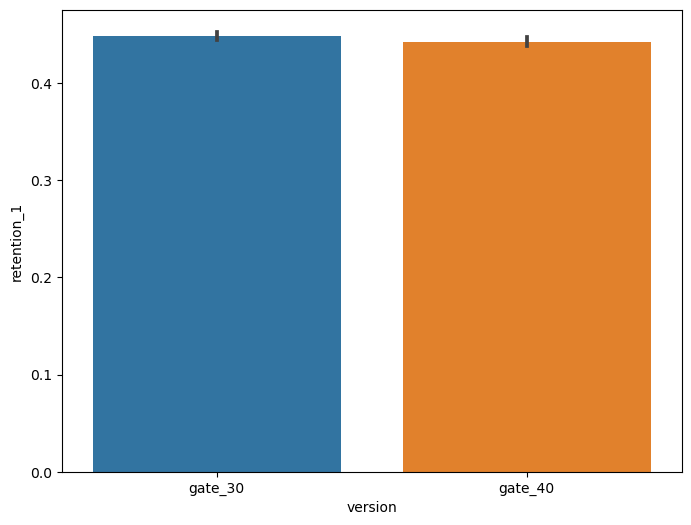

In [35]:
plt.figure(figsize=(8,6))

sns.barplot(x=cuki['version'], 
            y=cuki['retention_1'])


Testeo de hipotesis

In [36]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

Se saca la cantidad de conversiones tanto de la muestra como del tratamiento

In [37]:
control = cuki[cuki.version == 'gate_30']['retention_1']
tratamiento = cuki[cuki.version == 'gate_40']['retention_1']

In [44]:
impresiones=[44700, 44700]  # count  , impresiones
    
conversiones=[control.sum(), tratamiento.sum()]    # conversiones

#se realiza un Z test para comparar las proporciones de conversiones entre los dos grupos

z_score, p_value = proportions_ztest(conversiones, nobs=impresiones)

#se calculan los intervalos de confianza 

(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, 
                                                                nobs=impresiones,
                                                                alpha=0.05)

In [45]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 1.85
p-valor: 0.064
intervalo conf 95% para grupo control: [0.444, 0.453]
intervalo conf 95% para grupo tratamiento: [0.437, 0.447]


Hay una probabilidad del 6,4% de obetner una diferencia en las proporciones de conversiones entre los grupos bajo la suposición de que no hay diferencia real entre los grupos

El pvalor no es lo suficientemente bajo como para rechazar la hipotesis nula 

### CON BAYES

In [50]:
from scipy.stats import bernoulli, beta  

In [51]:
pd.crosstab(cookie.version, cookie.retention_1)


retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [52]:


t_ctrl, totalc = 20034, 44700    # true, total

t_test, totalt = 20119, 45489 

#saco las tasas de conversión

CR_ctrl = t_ctrl/totalc
CR_test = t_test/totalt

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'


'Tasas conversion: Control: 0.4481879194630872, Test: 0.44228274967574577'

In [55]:
# a prioris con distribución beta

a_C, b_C = 1+t_ctrl, 1+totalc-t_ctrl

a_T, b_T = 1+t_test, 1+totalt-t_test

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [56]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [65]:
x=np.linspace(0.425, 0.47, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();



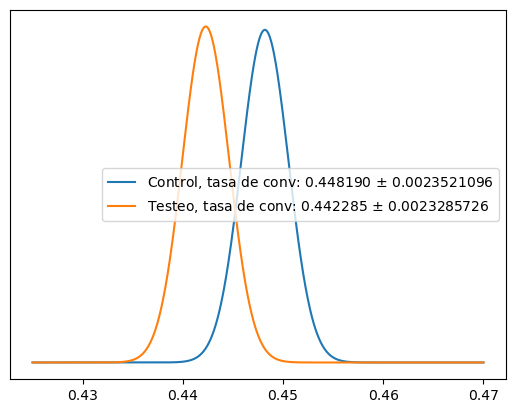

In [66]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

Salto entre las medias de las distribuciones beta de ambos grupos

In [67]:
salto = (beta_test.mean() - beta_control.mean())/beta_control.mean()

salto

-0.013175098158249857

In [68]:
from bayes import *

In [71]:
cruce = calc_prob(beta_test, beta_control)

Probabilidad de que el grupo de tratamieno sea mayor al cruce entre las dos distribuciones



In [72]:
prob = 1 - beta_test.cdf(cruce)

prob

1.0

In [73]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test aumenta la tasa de conversion en un -1.32%, con una probabilidad del 100.00%'

# RETENTION 7

Con Bayes:

In [74]:
pd.crosstab(cookie.version, cookie.retention_7)

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [75]:
t_ctrl, totalc = 8502, 36198 + 8502    # true, total

t_test, totalt = 8279, 37210 + 8279 


CR_ctrl = t_ctrl/totalc
CR_test = t_test/totalt

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.19020134228187918, Test: 0.18200004396667327'

In [76]:
# a prioris

a_C, b_C = 1+t_ctrl, 1+totalc-t_ctrl

a_T, b_T = 1+t_test, 1+totalt-t_test

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

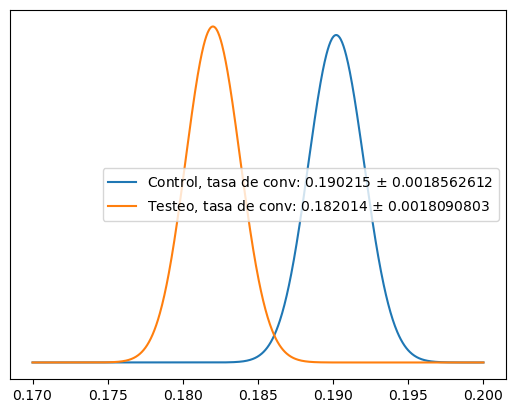

In [83]:
x=np.linspace(0.17, 0.2, 1000)



def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

plot([beta_control, beta_test], ['Control', 'Testeo'])

In [84]:
salto = (beta_test.mean() - beta_control.mean())/beta_control.mean()
cruce = calc_prob(beta_test, beta_control)
prob = 1 - beta_test.cdf(cruce)


'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)


'El test aumenta la tasa de conversion en un -4.31%, con una probabilidad del 100.00%'

En conclusión el testeo no es una buena idea llevarlo a cabo ya que no presenta resultados positivos si no que disminuye la tasa de conversión además con una probabilidad del 100% 